In [1]:
import pandas as pd

In [2]:
df = pd.read_excel('../../data_set/monthlyInvestigation/cleaned_monthly_investigations.xlsx')

In [3]:
df.sort_values(['Subject_ID', 'Month'], inplace=True)

# Create the target variable by shifting Hb column backward by 1 month for each patient
df['Next_Hb'] = df.groupby('Subject_ID')['Hb (g/dL)'].shift(-1)


df['Risk_Label'] = df['Next_Hb'].apply(lambda x: 1 if x < 10 or x > 12 else 0)


df['Hb_diff'] = df['Hb (g/dL)'] - df.groupby('Subject_ID')['Hb (g/dL)'].shift(1)

df = df.dropna(subset=['Next_Hb', 'Risk_Label'])


feature_cols = [
    'Albumin (g/L)', 'BU - post HD', 'BU - pre HD', 'S Ca (mmol/L)',
    'SCR- post HD (µmol/L)', 'SCR- pre HD (µmol/L)',
    'Serum K Post-HD (mmol/L)', 'Serum K Pre-HD (mmol/L)',
    'Serum Na Pre-HD (mmol/L)', 'UA (mg/dL)', 'Hb_diff', 'Hb (g/dL)'
]

from sklearn.model_selection import GroupShuffleSplit

gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(gss.split(df, groups=df['Subject_ID']))

X_train = df.iloc[train_idx][feature_cols]
y_train = df.iloc[train_idx]['Risk_Label']

X_test = df.iloc[test_idx][feature_cols]
y_test = df.iloc[test_idx]['Risk_Label']

In [4]:
y_train.value_counts(), y_test.value_counts()

(Risk_Label
 1    184
 0    104
 Name: count, dtype: int64,
 Risk_Label
 1    38
 0    30
 Name: count, dtype: int64)

In [5]:
from xgboost import XGBClassifier
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import classification_report, confusion_matrix

# Compute sample weights for class imbalance
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

# XGBoost classifier with manually specified hyperparameters
xgb_model = XGBClassifier(
    objective='multi:softmax',
    num_class=3,
    use_label_encoder=False,
    eval_metric='mlogloss',
    learning_rate=0.01,
    max_depth=5,
    n_estimators=100,
    subsample=1.0,
    colsample_bytree=1.0,
    random_state=42
)

# Train model
xgb_model.fit(X_train, y_train, sample_weight=sample_weights)

# Predict
y_pred = xgb_model.predict(X_test)

# Evaluation
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:\n", cm)
print("\nClassification Report:\n", classification_report(y_test, y_pred))



Confusion Matrix:
 [[24  6]
 [16 22]]

Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.80      0.69        30
           1       0.79      0.58      0.67        38

    accuracy                           0.68        68
   macro avg       0.69      0.69      0.68        68
weighted avg       0.70      0.68      0.68        68



c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\training.py:183: UserWarning: [10:52:17] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


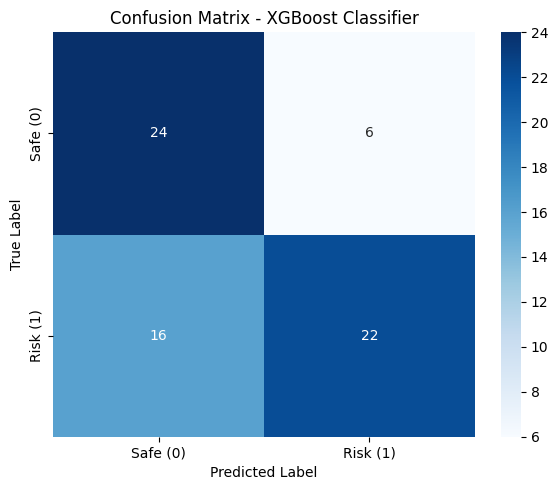

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Safe (0)', 'Risk (1)'],
            yticklabels=['Safe (0)', 'Risk (1)'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - XGBoost Classifier')
plt.tight_layout()
plt.show()

AUC Score: 0.73


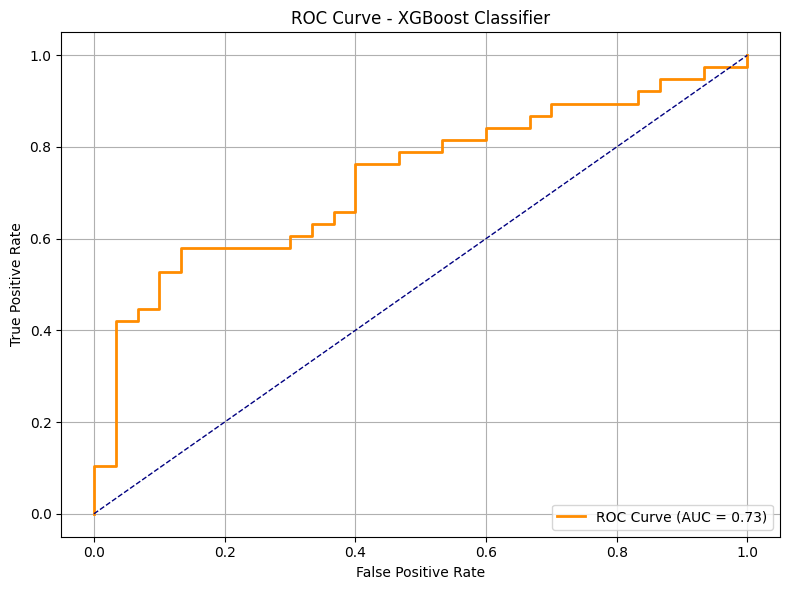

In [7]:
from sklearn.metrics import roc_auc_score, roc_curve, RocCurveDisplay
import matplotlib.pyplot as plt

y_test_proba = xgb_model.predict_proba(X_test)[:, 1]

# Compute AUC score
auc_score = roc_auc_score(y_test, y_test_proba)
print(f"AUC Score: {auc_score:.2f}")

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - XGBoost Classifier')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()